In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['source']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
import pyhf
import logging
logging.basicConfig(level = logging.INFO)
from pyhf import hfpdf
def prep_data(sourcedata):
    spec =  {
        'channels': [
            {
                'name': 'signal',
                'samples': [
                    {
                        'name': 'signal',
                        'data': sourcedata['signal']['bindata']['sig'],
                        'modifiers': [
                            {
                                'name': 'mu',
                                'type': 'normfactor',
                                'data': None
                            }
                        ]
                    },
                    {
                        'name': 'bkg1',
                        'data': sourcedata['signal']['bindata']['bkg1'],
                        'modifiers': [
                            {
                                'name': 'coupled_histosys',
                                'type': 'histosys',
                                'data':  {'lo_data': sourcedata['signal']['bindata']['bkg1_dn'], 'hi_data': sourcedata['signal']['bindata']['bkg1_up']}
                            }
                        ]
                    },
                    {
                        'name': 'bkg2',
                        'data': sourcedata['signal']['bindata']['bkg2'],
                        'modifiers': [
                            {
                                'name': 'coupled_histosys',
                                'type': 'histosys',
                                'data':  {'lo_data': sourcedata['signal']['bindata']['bkg2_dn'], 'hi_data': sourcedata['signal']['bindata']['bkg2_up']}
                            }
                        ]
                    }
                ]
            },
            {
                'name': 'control',
                'samples': [
                    {
                        'name': 'background',
                        'data': sourcedata['control']['bindata']['bkg1'],
                        'modifiers': [
                            {
                                'name': 'coupled_histosys',
                                'type': 'histosys',
                                'data':  {'lo_data': sourcedata['control']['bindata']['bkg1_dn'], 'hi_data': sourcedata['control']['bindata']['bkg1_up']}
                            }
                        ]
                    }
                ]
            }
        ]
    }
    pdf  = hfpdf(spec)
    data = []
    for c in pdf.spec['channels']:
        data += sourcedata[c['name']]['bindata']['data']
    data = data + pdf.config.auxdata
    return data, pdf

In [6]:
validation_datadir = '../../validation/data'

In [7]:
import json
source = json.load(open(validation_datadir + '/2bin_2channel_coupledhisto.json'))


d,pdf = prep_data(source['channels'])

print (d)

init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

unconpars = pyhf.optimizer.unconstrained_bestfit(pyhf.loglambdav,d,pdf,init_pars,par_bounds)
print ('UNCON',unconpars)

conpars = pyhf.optimizer.constrained_bestfit(pyhf.loglambdav,0.0,d,pdf,init_pars,par_bounds)
print ('CONS', conpars)

pdf.expected_data(conpars)

INFO:pyhf:adding modifier coupled_histosys (1 new nuisance parameters)
INFO:pyhf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf:accepting existing histosys
INFO:pyhf:accepting existing histosys


[110.0, 105.0, 170.0, 220.0, 0]
('UNCON', array([0.31261024, 0.50055858]))
('CONS', array([0.15300933, 0.        ]))


/Users/lukas/Code/histfactory/pyhf/pyhf/__init__.py:15: RuntimeWarning: invalid value encountered in log
  return np.exp(n*np.log(lam)-lam-gammaln(n+1.))


array([1.05765047e+02, 1.02295140e+02, 1.52295140e+02, 2.11584487e+02,
       1.53009331e-01])

/Users/lukas/Code/histfactory/pyhf/pyhf/__init__.py:401: RuntimeWarning: divide by zero encountered in double_scalars
  CLs = CLb / CLsb


{'exp': [0.3488630389652413,
  0.4720997240735826,
  0.6568947869445266,
  0.9271407096392055,
  1.2665933117030255],
 'obs': 1.0836849242026667}

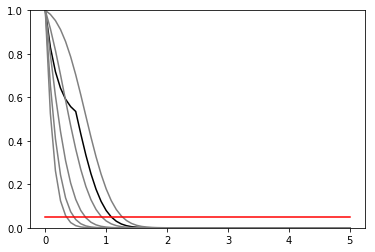

In [8]:
def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def CLsOnePoint(muTest,d,pdf, init_pars,par_bounds):
    clsobs, cls_exp = pyhf.runOnePoint(muTest, d,pdf,init_pars,par_bounds)[-2:]
    return 1./clsobs, [1./x for x in cls_exp]

def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross


CLsOnePoint(1.0,d,pdf,init_pars,par_bounds)


mutests = np.linspace(0,5,61)
tests = [CLsOnePoint(muTest,d,pdf,init_pars,par_bounds) for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]

plot_results(mutests, cls_obs, cls_exp)

invert_interval(mutests, cls_obs, cls_exp)


